# in the name of Allah

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

# For LSTM model
from keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [ ]:
df = pd.read_csv("/content/DIS.csv",header=None)

In [ ]:
df.head()

0          1          2          3          4          5        6
0  1996-12-31  23.011177  23.175543  22.805719  22.928993  17.804647  2719200
1  1997-01-02  22.928993  22.970085  21.942801  22.148258  17.198397  8115400
2  1997-01-03  22.394806  22.805719  22.394806  22.764629  17.677013  4650000
3  1997-01-06  22.764629  22.928993  22.559172  22.682446  17.613201  3623300
4  1997-01-07  22.682446  22.682446  22.435898  22.641354  17.581289  3606200

In [ ]:
df.rename(columns={0: 'date', 1: 'open', 2:"high",3:"low",4:"close",5:"adj_close",6:"volume"},inplace=True)

In [ ]:
df.describe()

open         high          low        close    adj_close  \
count  5035.000000  5035.000000  5035.000000  5035.000000  5035.000000   
mean     41.476292    41.894942    41.044495    41.488691    37.013303   
std      25.585786    25.699734    25.447581    25.578599    25.837173   
min      13.609468    13.905326    13.293885    13.579882    10.986330   
25%      25.501548    25.838264    25.216962    25.517752    20.857732   
50%      32.011833    32.445759    31.610001    32.020000    27.182140   
75%      42.029999    42.403157    41.700001    42.040001    38.381932   
max     121.500000   122.080002   120.610001   121.690002   117.301552   

             volume  
count  5.035000e+03  
mean   8.798791e+06  
std    5.412092e+06  
min    6.552000e+05  
25%    5.608300e+06  
50%    7.591700e+06  
75%    1.052490e+07  
max    1.166250e+08

In [ ]:
train, test = train_test_split(df, test_size=0.5)

In [ ]:
# scaler = StandardScaler()
# X = scaler.fit_transform(df[["open","high","low","close","adj_close","volume"]])

# Scale features
s1 = MinMaxScaler(feature_range=(0,1))
Xs = s1.fit_transform(train[["open","high","low","close","adj_close","volume"]])

# Scale predicted value
s2 = MinMaxScaler(feature_range=(0,1))
Ys = s2.fit_transform(train[['adj_close']])


# Each time step uses last 'window' to predict the next change
window = 240
X = []
Y = []

for i in range(window,len(Xs)):
    X.append(Xs[i-window:i,:])  ### 70 karakter aval ro migire, 71 omin ro hads mizane. va hamin tori amizesh mibine.
    Y.append(Ys[i])

In [ ]:
# Reshape data to format accepted by LSTM
X, Y = np.array(X), np.array(Y)

In [ ]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
# create and train LSTM model

# Initialize LSTM model

model = Sequential()
model.add(LSTM(units=100, return_sequences=True,input_shape=(X.shape[1],X.shape[2])))
model.add(Dropout(0.25))
model.add(LSTM(units=100))
model.add(Dropout(0.25))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss='mean_squared_error',metrics=[RootMeanSquaredError()])

In [ ]:
# # Allow for early exit 
# es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=50)

# Fit (and time) LSTM model
t0 = time.time()
history = model.fit(X, Y, epochs = 1000, batch_size = 240, verbose=1 )
t1 = time.time()

print('Runtime: %.2f min' %((t1-t0)/60))

Epoch 1/1000
10/10 [==============================] - 3s 47ms/step - loss: 0.0741 - root_mean_squared_error: 0.2722
Epoch 2/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0673 - root_mean_squared_error: 0.2593
Epoch 3/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0657 - root_mean_squared_error: 0.2563
Epoch 4/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0655 - root_mean_squared_error: 0.2558
Epoch 5/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0653 - root_mean_squared_error: 0.2556
Epoch 6/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.0648 - root_mean_squared_error: 0.2545
Epoch 7/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.0642 - root_mean_squared_error: 0.2534
Epoch 8/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0646 - root_mean_squared_error: 0.2541
Epoch 9/1000
10/10 [==============================] - 0s 37ms/step - los

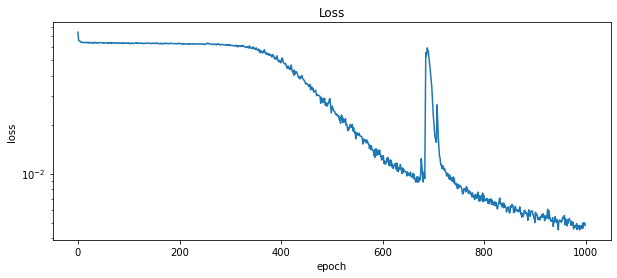

In [ ]:
# Plot loss

plt.figure(figsize=(10,4))
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); 
plt.ylabel('loss')
plt.title('Loss')
plt.savefig('stock_loss.png')
model.save('model.h5')

In [ ]:
# Verify the fit of the model
Yp = model.predict(X)

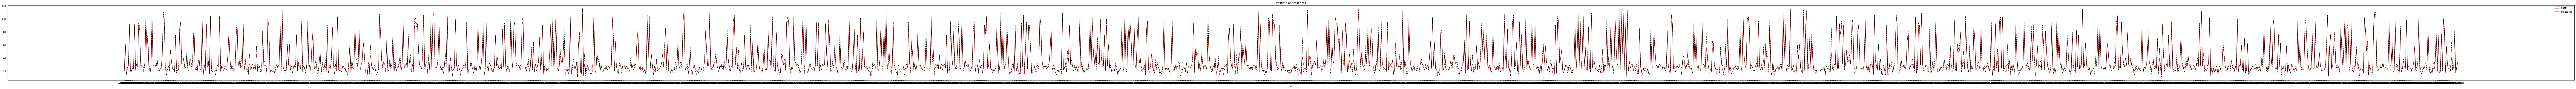

In [ ]:
# un-scale outputs

Yu = s2.inverse_transform(Yp)
Ym = s2.inverse_transform(Y)

plt.figure(figsize=(200,6))
plt.plot(train['date'][window:],Yu,'r-',label='LSTM')
plt.plot(train['date'][window:],Ym,'k--',label='Measured')
plt.legend()
plt.title("validate on train data")
plt.xlabel("Time")
plt.savefig('price_fit.png')

In [ ]:
# Load model
v = load_model('model.h5')

In [ ]:
# Load training data

Xt = test[["open","high","low","close","adj_close","volume"]].values
Yt = test[['adj_close']].values

Xts = s1.transform(Xt)
Yts = s2.transform(Yt)

Xti = []
Yti = []
for i in range(window,len(Xts)):
    Xti.append(Xts[i-window:i,:])
    Yti.append(Yts[i])

# Reshape data to format accepted by LSTM
Xti, Yti = np.array(Xti), np.array(Yti)

In [ ]:
# Verify the fit of the model
Ytp = model.predict(Xti)

No handles with labels found to put in legend.


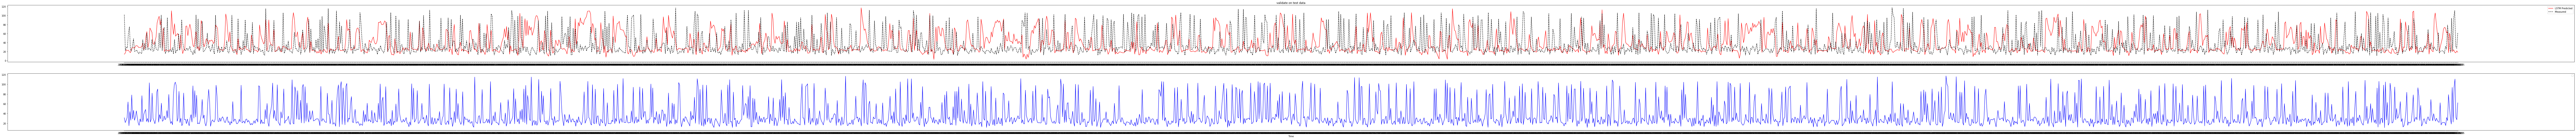

In [ ]:
# un-scale outputs
Ytu = s2.inverse_transform(Ytp)
Ytm = s2.inverse_transform(Yti)

plt.figure(figsize=(200,10))
plt.subplot(2,1,1)
plt.plot(test['date'][window:],Ytu,'r-',label='LSTM Predicted')
plt.plot(test['date'][window:],Ytm,'k--',label='Measured')
plt.legend()
plt.title("validate on test data")

plt.subplot(2,1,2)
plt.plot(test['date'],test['adj_close'],'b-')
plt.xlabel('Time');
plt.legend()
plt.savefig('price_validate.png')